In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
import os, sys
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-2*I/A)+vmin

def solution(phi,t,vmax,D_0):
    return exp(-t*vmax**2/(4*D_0))/(4*np.pi) * (2+exp(t*vmax**2*sin(phi)**2/(4*D_0))*sqrt(np.pi/(D_0*t))*t*vmax*sin(phi) + exp(t*vmax**2*sin(phi)**2/(4*D_0))*sqrt(np.pi*t/D_0)*vmax*sin(phi)*scipy.special.erf(sqrt(t/D_0)*vmax*sin(phi)/2))

def msd_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average((x[i:] - x[:-i])**2)
    return result

def chi2(ydata,Nparams,f, *params):
    res = ydata - f(*params)
    redchi2 = sum(res**2)/(len(ydata)-Nparams)
    return res, redchi2

def acfangle_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average(np.cos((x[i:] - x[:-i])*np.pi/180))
    result[0] = 1
    return result

def expfun(x,lp):
    return np.exp(-x/lp)

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def msd_2d(x,y):
    result = np.zeros_like(x)
    for i in range(1,len(x)): result[i] = np.average(pow(x[i:] - x[:-i],2)+pow(y[i:] - y[:-i],2))
    return result

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

def analyseTDMS(file):
    # Print properties and channels of TDMS file
    tdms_file = TdmsFile(file)
    print('Properties (Root):')
    for name, value in tdms_file.object().properties.items():
        print(2*' ' + "{0}: {1}".format(name, value))
    for group in tdms_file.groups():
        print('\'' + group + '\'')
        print(2*' ' + 'Properties (' + '\'' + group + '\'' ')')
        for name, value in tdms_file.object(group).properties.items():
            print('')
        for channel in tdms_file.group_channels(group):
            print(2*' ' + channel.channel)
            
def curve(r,sigma,mu): return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(r - mu)**2/(2*sigma**2))

def curve2(r):
    return 1/np.sqrt(4*np.pi*D_0*dt) * np.exp(-(r - mu)**2/(4*D_0*dt))

def curve3(r,A,sigma,mu):
    return A * np.exp(-(r - mu)**2/(sigma))

In [2]:
number=16
printnum=number
folder = "/Users/alex/Documents/Measurements/200707 - Alex Test"
loadvideofile = False
if loadvideofile == False:
    dt = 0.05
    videosize = 512

pxtomum=0.0533#0.0719e-6
#boundaryradius = 180
maxpower = 0.5
steps = 11

R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14

amplitude = 1
start_time = time.time()   
if number < 10:
        tdms_file = TdmsFile(folder+"/Test_00"+str(number)+"_module.tdms")
        analyseTDMS(folder+"/Test_00"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_00"+str(number)+"_module.tdms")
else:
    if number < 100:
        tdms_file = TdmsFile(folder+"/Test_0"+str(number)+"_module.tdms")
        analyseTDMS(folder+"/Test_0"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_0"+str(number)+"_module.tdms")
    else:
        tdms_file = TdmsFile(folder+"/Test_"+str(number)+"_module.tdms")
        analyseTDMS(folder+"/Test_"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_"+str(number)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

Xc = tdms_file.channel_data('Data','Xc')
Yc = tdms_file.channel_data('Data','Yc')
velocitytheo = tdms_file.channel_data('Data','Velocity')
angletheo = tdms_file.channel_data('Data','Angle')
xolaser = tdms_file.channel_data('Data','Xh')
yolaser = tdms_file.channel_data('Data','Yh')
Nfound = tdms_file.channel_data('Data','N')
Nlaser = tdms_file.channel_data('Data','NLaser')
delaywave = tdms_file.channel_data('Data','Delays')
iterationtime = tdms_file.channel_data('Data','Iterationtime')
programtime = tdms_file.channel_data('Data','Programtime')
p = tdms_file.object().properties
delay = int(p['Delay'])
noise = int(p['Sigmanoise'])
boundaryradius = p['Boundary']
offset = p['Offset']
sigmavelo = p['Sigmavelo']
vmin = p['Vmin']
vmax = p['Vmax']
vfactor = vmax - vmin
maxlength = len(Nfound)-1
stepsexp = maxlength
if loadvideofile == True:
    dt = kinetic_cycle
videosize = p['Xsize']
timewave=np.linspace(0,maxlength*dt,maxlength)
dtprogram = 13.6e-3                             #time of the program (tracking + calculation) [s]
dtsendtoadwin = 1e-3                            #time to send signal from PC to Adwin [s]
dttransferfromcamtocom = 1e-3                   #time to send from cam to PC (unknown) [s]
dtframetransfer = videosize * 1.9176e-6         #time for frametransfer [s]
dtreadout = (1032/(27e6) + 1.9176e-6)*videosize #time to readout the cam [s]

print('size of the video = ',videosize)
print('length of the movie = ',maxlength)

Properties (Root):
  Boundary: 300.0
  CycleTime: 0.0
  Delay: 13
  Offset: -10.0
  Sigmanoise: 12.977713690461004
  Sigmavelo: 50.0
  Tau_r: 100.0
  Threshold: 5000
  Vmax: 1.0
  Vmin: 1.0
  Xsize: 800
'Data'
  Properties ('Data')
  Angle
  Delays
  Iterationtime
  N
  NLaser
  Phase
  Programtime
  Velocity
  Xc
  Xh
  Yc
  Yh
--- 16.49 seconds ---
size of the video =  800
length of the movie =  4101


 
Trajectory length
[ 4100.  4100.  4100.]


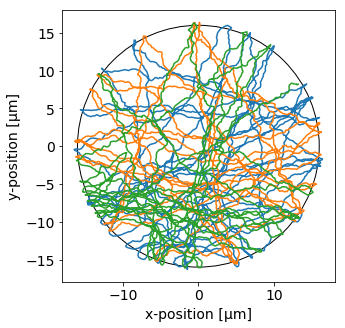

In [9]:
number = int(stats.mode(Nfound))
maxnumber = int(max(Nfound))

particles = np.zeros((maxlength,number,6))
lastone = np.zeros((number,2))
pre = np.zeros((maxlength,maxnumber,6))
count = 0
for i in range(maxlength):
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        pre[i,j,2] = velocitytheo[count]
        pre[i,j,3] = angletheo[count]
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        count += 1

particles[0,:,:] = pre[0,:number,:]
for i in range(1,maxlength):
    for j in range(number):
        if particles[i-1,j,0] != 0:
            lastone[j,0] = i-1
            lastone[j,1] = 0
        else: lastone[j,1] += 1
        xpre = particles[int(lastone[j,0]),j,0]
        ypre = particles[int(lastone[j,0]),j,1]
        mindist = 20; minnum = 666
        for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
            dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
            if dist < mindist:
                mindist = dist
                minnum = k
                #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
        if minnum != 666: particles[i,j,:] = pre[i,minnum,:]
        
for i in range(1,maxlength):
    for j in range(number):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan     
particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
save = particles

#print('Fill gaps at:')
trajlength = np.zeros(number)
for j in range(number):
    lastfound = 0; out = True
    for i in range(1,maxlength):
        if out == True:
            if particles[i,j,0] != particles[i,j,0]:
                lastfound = int(i-1)
                count = 1; check = True
                while check == True:
                    if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                        #print('j = ',j,' - i = ',i,' - gap = ',count)
                        check = False
                    else: count +=1
                    if count == 20:
                        print('Failed at j = ',j,' - i = ',i)
                        check = False
                        trajlength[j] = lastfound
                        particles[lastfound:,j,0] = np.nan
                        particles[lastfound:,j,1] = np.nan
                        out = False
                #print('particle number = ',j,' - position = ',i,' gap length = ',count)
                if out == True:
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    for k in range(1,count+1):
                        particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                        particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                        particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                        particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                    #print('AFTER')
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    #print('----------')
            if i == maxlength-1: 
                trajlength[j] = i
print(' ')
print('Trajectory length')                  
print(trajlength)


fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(number):
    ax.plot(particles[:,i,0],particles[:,i,1])
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
plt.show()

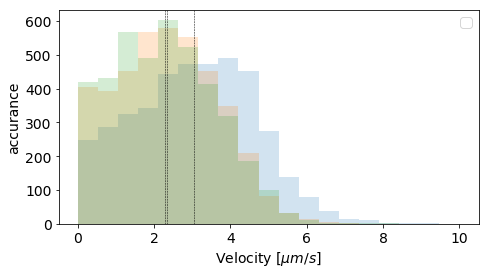

velocity particle 1 : 3.04  µm/s
velocity particle 2 : 2.35  µm/s
velocity particle 3 : 2.27  µm/s


In [4]:
directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros((maxlength,number));stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros((maxlength,number))
velocity2 = np.zeros((maxlength,number,2))

for j in range(number):
    directionvector[:,0] = np.cos(particles[:,j,2]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,j,2]*np.pi/180)
    for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
        movingvector[i,0] = particles[i,j,0]-particles[i-1,j,0]
        movingvector[i,1] = particles[i,j,1]-particles[i-1,j,1]
        stepsize[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))
        velocity[i,j] = stepsize[i]/dt
        velocitywithdiffusion[i,j] = np.sqrt(pow(movingvector[i,0],2)+pow(movingvector[i,1],2))/dt 
        distance = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        if distance < boundaryradius*pxtomum:
            velocity2[i,j,0] = velocity[i,j]
            velocity2[i,j,1] = velocitywithdiffusion[i,j]
for j in range(number):
    for i in range(maxlength):
        if velocity2[i,j,0] == 0: velocity2[i,j,:]=np.nan
        
binwave=np.linspace(np.amin(velocity),min(np.amax(velocitywithdiffusion),10),20)
fig=plt.figure(1, figsize = (7,4) )
plt.subplot(1,1,1)
for i in range(number):
    wave = velocity[:,i]    
    plt.hist(wave[~np.isnan(wave)], bins=binwave,alpha = 0.2)
    plt.axvline(x=np.nanmean(wave),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
#plt.savefig('Histogram Stepsize'+str(num)+'.pdf', format='pdf')
plt.show() 

for i in range(number): print('velocity particle',str(i+1),':',round(np.mean(velocity[:,i]),2),' µm/s')

/Users/alex/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


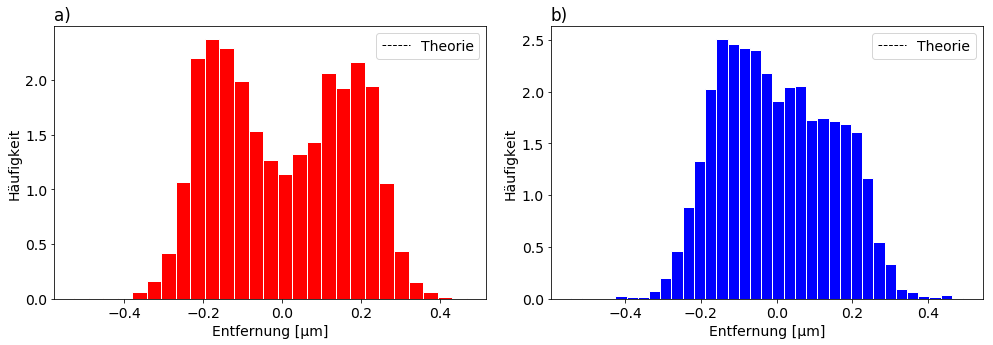

 D  theory =  3.85e-14
 Dx exp sig=  3.85e-14
 Dy exp sig=  3.85e-14
Drift x =  0.0  nm - y =  0.0  nm


In [6]:
which = 0
mu=0
realxsteps = np.zeros(maxlength);realysteps = np.zeros(maxlength)
for i in range(1,maxlength):
    realxsteps[i] = (particles[i,which,0]-particles[i-1,which,0])
    realysteps[i] = (particles[i,which,1]-particles[i-1,which,1])

fig=plt.figure(1, figsize = (14,5) )
plt.subplot(1,2,1)
histo, bins, patches = plt.hist(realxsteps,bins='auto',normed=1,color='r',edgecolor="#FFFFFF");
rscale=np.linspace(bins[0],bins[len(bins)-1],100)
plt.plot(rscale,curve2(rscale),'k--',lw=1,label='Theorie') 
fitbins = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    fitbins[i] = (bins[i]+bins[i+1])/2
popt,pcov = curve_fit(curve3, fitbins, histo,p0 = (1/np.sqrt(4*np.pi*D_0*dt),4*D_0*dt,mu))
pErr = np.sqrt(np.diag(pcov))
plt.plot(rscale,curve3(rscale,*popt),'k-',lw=1) 
savex = popt
plt.title('a)', loc = 'left')
plt.xlabel('Entfernung [µm]')#$\mu$
plt.ylabel('Häufigkeit')
plt.legend()

plt.subplot(1,2,2)
histo, bins, patches = plt.hist(realysteps,bins='auto',normed=1,color='b',edgecolor="#FFFFFF");
rscale=np.linspace(bins[0],bins[len(bins)-1],100)
plt.plot(rscale,curve2(rscale),'k--',lw=1,label='Theorie') 
fitbins = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    fitbins[i] = (bins[i]+bins[i+1])/2
popt,pcov = curve_fit(curve3, fitbins, histo,p0 = (1/np.sqrt(4*np.pi*D_0*dt),4*D_0*dt,mu))
pErr = np.sqrt(np.diag(pcov))
plt.plot(rscale,curve3(rscale,*popt),'k-',lw=1) 
savey = popt
plt.title('b)', loc = 'left')
plt.xlabel('Entfernung [µm]')#$\mu$
plt.ylabel('Häufigkeit')
plt.legend()
plt.tight_layout()
plt.show()


print(' D  theory = ',D_0)
print(' Dx exp sig= ',abs(savex[1])/(4*dt) )
print(' Dy exp sig= ',abs(savey[1])/(4*dt) )
print('Drift x = ',round(savex[2]*1e9,2),' nm - y = ',round(savey[2]*1e9,2),' nm')
#print(' D exp pre= ',1/(4*np.pi*dt*pow(savex[0],2)))

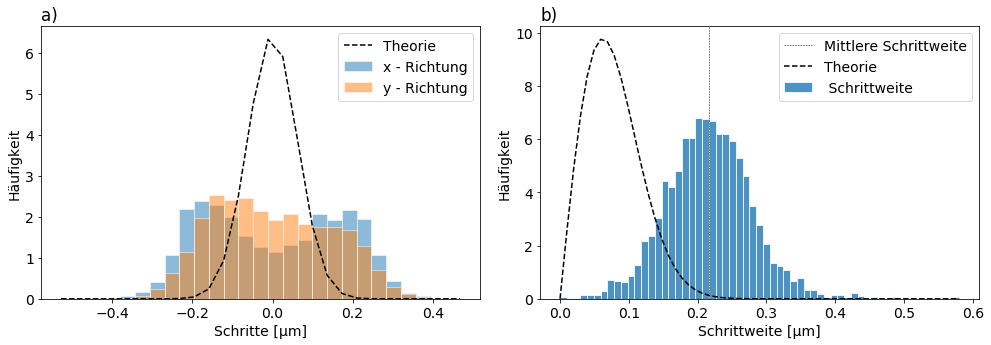

mean step size =  0.216  µm


In [7]:
prefactor = np.sqrt(2*D_0*dt)
sigma=prefactor
mu=0
steplength = np.sqrt(pow(realxsteps[:],2)+pow(realysteps[:],2))

fig=plt.figure(1, figsize = (14,5) )
plt.subplot(1,2,1)
histo, bins, patches = plt.hist(realxsteps[:],bins='auto',density=1,label = 'x - Richtung',alpha = 0.5, edgecolor="#FFFFFF")
rscale=np.linspace(bins[0],bins[len(bins)-1],len(bins)) 
rscalem=np.linspace(bins[0]*1e-6,bins[len(bins)-1]*1e-6,len(bins)) 
histo, bins, patches = plt.hist(realysteps[:],bins=rscale,density=1,label = 'y - Richtung',alpha = 0.5, edgecolor="#FFFFFF")
plt.plot(rscale,curve(rscalem,sigma,mu)*1e-6,'k--',lw=1.5,label='Theorie')
plt.title('a)', loc='left')
plt.xlabel('Schritte [µm]')
plt.ylabel('Häufigkeit')
plt.legend()

sigma = np.sqrt(2*D_0*dt)
plt.subplot(1,2,2)
histo, bins, patches = plt.hist(steplength,bins='auto',density=1,label = ' Schrittweite',alpha = 0.8, edgecolor="#FFFFFF")
plt.axvline(x=np.mean(steplength),linewidth=0.5, color = 'k',linestyle='--',label='Mittlere Schrittweite')
rscale2=np.linspace(bins[0],bins[len(bins)-1],len(bins)) 
rscale2m=np.linspace(bins[0]*1e-6,bins[len(bins)-1]*1e-6,len(bins)) 
plt.plot(rscale2,rscale2m/sigma**2*np.exp(-rscale2m**2/(2*sigma**2))*1e-6,'k--',lw=1.5,label='Theorie')
plt.title('b)', loc='left')
plt.xlabel('Schrittweite [µm]')
plt.ylabel('Häufigkeit')
plt.legend()
plt.tight_layout()
plt.savefig('SchrittweiteGemessen.pdf')
plt.show()

meanstepsize = np.mean(steplength)
print('mean step size = ',round(meanstepsize,3),' µm')

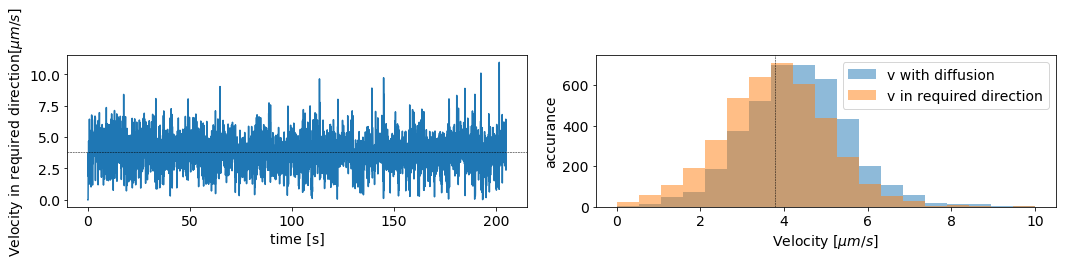

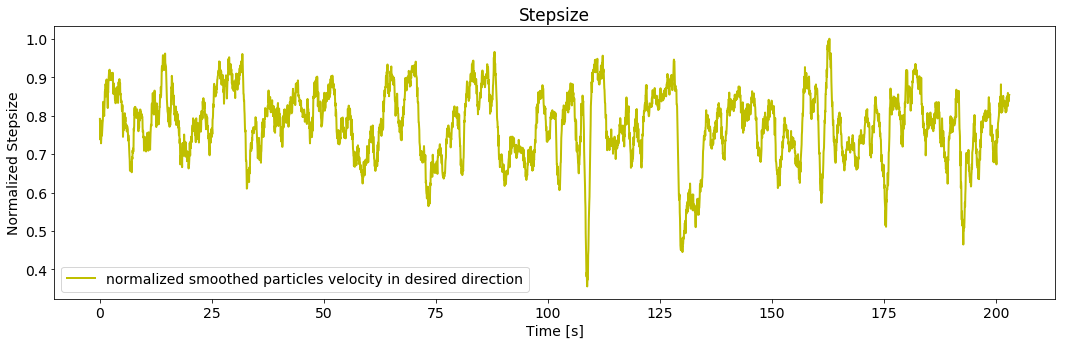

single particle =  3.788  +-  1.661  µm/s   max velocity =  10.957   µm/s
mean distance to the center =  10.19  µm


In [25]:
particlesdisplay = np.zeros((maxlength,1,5))
particlesdisplay[:,0,0] = particles[:,0,0];particlesdisplay[:,0,1] = particles[:,0,1]
#particlesdisplay = (particlesdisplay-videosize/2)*pxtomum
directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros(maxlength)
directionvector[:,0] = np.cos(particles[:,0,3]*np.pi/180)
directionvector[:,1] = np.sin(particles[:,0,3]*np.pi/180)
for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
    movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
    movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
    stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
    velocity[i] = stepsize[i]/dt
velocitywithdiffusion[:] = np.sqrt(pow(movingvector[:,0],2)+pow(movingvector[:,1],2))/dt 
distancetocenter=[]                                    #Calc velocity 
distancetocenter=np.sqrt(pow(particles[:,0,0],2)+pow(particles[:,0,1],2))
binwave=np.linspace(min(velocity),min(max(velocitywithdiffusion),10),20)
countin = 0
for i in range(maxlength):
    if distancetocenter[i] < sigmavelo*pxtomum: countin += 1
countin /= maxlength
meanvelocity = np.mean(velocity)

fig=plt.figure(1, figsize = (15,3.5) )
plt.subplot(1,2,1)
plt.xlabel('time [s]')
plt.ylabel('Velocity in required direction[$\mu m/s$]')
plt.plot(np.arange(maxlength)*dt,velocity)
plt.axhline(y=np.mean(velocity),linewidth=0.5, color = 'k',linestyle='--')
plt.subplot(1,2,2)
plt.hist(velocitywithdiffusion, bins=binwave,alpha = 0.5,label='v with diffusion')
plt.hist(velocity, bins=binwave,alpha = 0.5,label='v in required direction')
plt.axvline(x=meanvelocity,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
plt.savefig('Histogram Stepsize'+str(printnum)+'.pdf', format='pdf')
plt.show() 

fig=plt.figure(1, figsize = (15,5) )
plt.title('Stepsize')
plt.xlabel('Time [s]')
plt.ylabel('Normalized Stepsize')
smoothvalue = 20
smoothit = smooth(velocity,smoothvalue)
xsmooth=np.linspace(0,dt*maxlength-2*smoothvalue*dt,maxlength-2*smoothvalue,endpoint=False)
plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/max(smoothit), 'y-', lw=2,label='normalized smoothed particles velocity in desired direction')
#plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/mean(smoothit), 'y-', lw=2,label='normalized smoothed particles speed')
#plt.plot(xsmooth,velo[smoothvalue:maxlength-smoothvalue], 'r-', lw=2,label='normalized required velocity')
plt.legend()
plt.tight_layout() 
plt.savefig('Stepsize vs time'+str(printnum)+'.pdf', format='pdf')
plt.show()

#np.savetxt('Datavelo'+str(printnum)+'.txt', np.transpose([velocity,smoothit,velo[:,0]]),fmt='%1.6f')
print('single particle = ',round(np.mean(velocity),3),' +- ',round(np.var(velocity),3),' µm/s   max velocity = ',round(max(velocity),3),'  µm/s')
print('mean distance to the center = ',round(np.mean(distancetocenter),2),' µm')

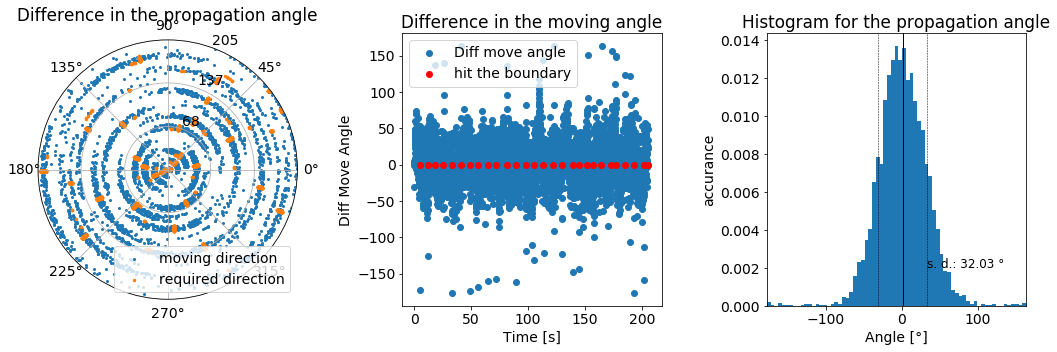

In [11]:
laserangle = np.zeros(maxlength);diffangle = np.zeros(maxlength)
moveangle = np.zeros(maxlength);diffmoveangle = np.zeros(maxlength)
delaylaserangle = 0   #in frames
delaydirection = 2    #in frames
angle = particles[:,0,3]

distancetocenter=[]
distancetocenter=np.sqrt(pow(particles[:,0,0],2)+pow(particles[:,0,1],2))
for i in range(maxlength):  
    dx = particles[i,0,0]-particles[i,0,4]             #Calc the angle of the laser
    dy = particles[i,0,1]-particles[i,0,5]
    laserangle[i] = np.arctan(dy/dx)*180/np.pi
    #laserangle[i] = - laserangle[i]
    if laserangle[i] != laserangle[i]: laserangle[i] = 90
    if dx > 0:
        if dy < 0: laserangle[i] += 360
    else: laserangle[i] += 180
    if laserangle[i]>360: laserangle[i] -= 360
    if i >= delaylaserangle:                      #Calc difference between required laser angle and real angle
        diffangle[i] = particles[i-delaylaserangle,0,3] - laserangle[i]
        if abs(diffangle[i]) > 180:
                if diffangle[i] > 0: diffangle[i] -= 360
                else: diffangle[i] += 360
        if abs(diffangle[i]) > 40: diffangle[i] = 0
            #print('Error laser? : i = ',i)
for i in range(1,maxlength):
    dx = particles[i,0,0]-particles[i-1,0,0]      #Calc moving direction
    dy = particles[i,0,1]-particles[i-1,0,1]
    moveangle[i] = np.arctan(dy/dx)*180/np.pi
    if moveangle[i] != moveangle[i]: moveangle[i] = 90
    if dx > 0:
        if dy < 0: moveangle[i] += 360
    else: moveangle[i] += 180
    if moveangle[i]>360: moveangle[i] -= 360
    if moveangle[i]<0: moveangle[i] += 360
    if i >= delaydirection:                       #Calc angle difference between required direction and real direction
        diffmoveangle[i] = particles[i-delaydirection,0,3] - moveangle[i]
        if abs(diffmoveangle[i]) > 180:
            if diffmoveangle[i] > 0: diffmoveangle[i] -= 360
            else: diffmoveangle[i] += 360
moveangle[0] = moveangle[1]
r = timewave
theta = moveangle*pi/180
theta2 = particles[:,0,3]*pi/180
theta3 = laserangle*pi/180

phiwave = np.linspace(0,2*np.pi,360,endpoint=False)
anglewave = np.linspace(-90,270,360,endpoint=False)
solutionwave = np.zeros(360)
for i in range(360): solutionwave[i] = solution(phiwave[i],dt,vmax,D_0)
solutionwave[:] /= sum(solutionwave[:]) 

angle2 = np.zeros(maxlength); angle2 = angle.copy()
for i in range(1,maxlength):
    if angle2[i] == 0:
        if i+2 < maxlength: angle2[i] = (angle2[i-1]+angle2[i+2])/2
        else: angle2[i] = angle2[i-1]
    if angle2[i] == 360:
        if i+2 < maxlength: angle2[i] = (angle2[i-1]+angle2[i+2])/2
        else: angle2[i] = angle2[i-1]
newangle = np.zeros(maxlength); newangle = angle2.copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,maxlength):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
newmoveangle = np.zeros(maxlength); newmoveangle = moveangle.copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,maxlength):
    diff[0] = abs(newmoveangle[i]-newmoveangle[i-1])
    diff[1] = abs(newmoveangle[i]-newmoveangle[i-1]+360)
    diff[2] = abs(newmoveangle[i]-newmoveangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newmoveangle[i:] += 360
        else: newmoveangle[i:] -= 360

oldstartpoint = []; oldendpoint =[]
if distancetocenter[0] < boundaryradius*pxtomum:
    oldstartpoint.append(0)
    check = 0
else: check = 1; remi = -1   
count = 0
for i in range(1,maxlength):
    if distancetocenter[i] > boundaryradius*pxtomum:
        if check == 0:
            remi = i
            check = 1
        count += 1
    if check == 1: 
        if distancetocenter[i] < boundaryradius*pxtomum:
            check = 0
            if remi != -1:
                oldstartpoint.append(i)
                oldendpoint.append(remi)
            else: oldstartpoint.append(i)
        else: count += 1   
if check == 1: oldendpoint.append(remi)
else: oldendpoint.append(maxlength-1)
            
sumstepsize = np.zeros(maxlength)
for i in range(1,maxlength): sumstepsize[i] = sumstepsize[i-1] + stepsize[i]
oldpathnumber = len(oldstartpoint)#;oldpathnumber = pathnumber
oldpathlength = np.zeros(oldpathnumber)
for i in range(oldpathnumber): oldpathlength[i] = int(oldendpoint[i]-oldstartpoint[i])
maxpathlength = int(max(oldpathlength))
oldmaxpathlength = int(max(oldpathlength))
oldstraightpaths = np.zeros((maxpathlength,oldpathnumber))
oldstraightpathssteps = np.zeros((maxpathlength,oldpathnumber))
anglestraightpaths = np.zeros((maxpathlength,oldpathnumber))
totallength = np.zeros(oldpathnumber)
count = 1
for i in range(oldpathnumber): 
    oldstraightpaths[:oldendpoint[i]-oldstartpoint[i],i] = newmoveangle[oldstartpoint[i]:oldendpoint[i]]
    anglestraightpaths[:oldendpoint[i]-oldstartpoint[i],i] = newangle[oldstartpoint[i]:oldendpoint[i]]
    oldstraightpathssteps[:oldendpoint[i]-oldstartpoint[i],i] = sumstepsize[oldstartpoint[i]:oldendpoint[i]]
    totallength[i] = sumstepsize[oldendpoint[i]-1] - sumstepsize[oldstartpoint[i]]
    particlesdisplay[oldstartpoint[i]:oldendpoint[i],0,4] = count
    count += 1   
for i in range(oldpathnumber):
    check = 0 
    while check == 0:
        if anglestraightpaths[0,i] > 360: anglestraightpaths[:int(oldpathlength[i]),i] -= 360
        if anglestraightpaths[0,i] < 0: anglestraightpaths[:int(oldpathlength[i]),i] += 360
        if anglestraightpaths[0,i] >= 0 and anglestraightpaths[0,i] <= 360: check = 1
for i in range(oldpathnumber):
    check = 0 
    while check == 0:
        if oldstraightpaths[0,i] > 360: oldstraightpaths[:int(oldpathlength[i]),i] -= 360
        if oldstraightpaths[0,i] < 0: oldstraightpaths[:int(oldpathlength[i]),i] += 360
        if oldstraightpaths[0,i] >= 0 and oldstraightpaths[0,i] <= 360: check = 1

fig=plt.figure(1, figsize = (15,5))
ax =plt.subplot(1,3, 1, projection='polar')
plt.title('Difference in the propagation angle')
ax.scatter(theta, r,s=4,label='moving direction')
ax.scatter(theta2[delaydirection:], r[:-delaydirection],s=6,label='required direction')
ax.set_rmax(max(timewave))
ax.set_rticks([round(max(timewave)/3,0), round(2*max(timewave)/3,0), round(max(timewave))])
ax.set_rlabel_position(70)
ax.grid(True)
plt.legend()

ax =plt.subplot(1, 3, 2)
plt.title('Difference in the moving angle')
plt.xlabel('Time [s]')
plt.ylabel('Diff Move Angle')
plt.scatter(timewave,diffmoveangle,label='Diff move angle',zorder=1)
tendx = np.zeros(len(oldendpoint)); tendy = np.zeros(len(oldendpoint))
for i in range(len(oldendpoint)): tendx[i] = oldendpoint[i] * dt
plt.scatter(tendx,tendy,color='r', zorder=2,label='hit the boundary')
plt.legend()

ax =plt.subplot(1, 3, 3)
plt.title('Histogram for the propagation angle')
plt.hist(diffmoveangle, bins='auto',normed=True)
plt.plot(anglewave,solutionwave)
plt.axvline(x=np.mean(diffmoveangle),linewidth=1, color = 'k',linestyle='-')
plt.axvline(x=np.mean(diffmoveangle)-np.std(diffmoveangle),linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=np.mean(diffmoveangle)+np.std(diffmoveangle),linewidth=0.5, color = 'k',linestyle='--')
plt.text(np.mean(diffmoveangle)+np.std(diffmoveangle),0.002,'s. d.: {:.2f} °'.format(np.std(diffmoveangle)),fontsize=12)
plt.xlabel('Angle [°]')
plt.ylabel('accurance')
plt.xlim([min(diffmoveangle),max(diffmoveangle)])
plt.tight_layout() 
plt.savefig('Analyze direction particle'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
plt.show()

## All stuff below is not so important

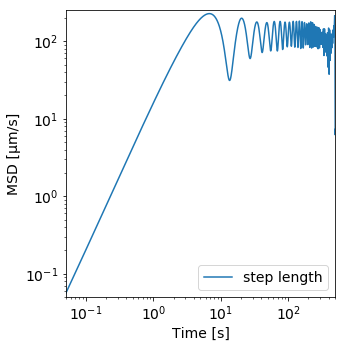

In [12]:
    result3 = msd_2d(particlesdisplay[:,0,0],particlesdisplay[:,0,1])
    plotlength = maxlength
    plotlength2 = maxlength*dt
    fig=plt.figure(1, figsize = (5,5) )
    plt.loglog(timewave,result3,label='step length')
    plt.xlabel('Time [s]')
    plt.ylabel('MSD [µm/s]')    
    plt.xlim([dt,plotlength2])
    plt.ylim([0.9*min(result3[1:plotlength]),1.1*max(result3[:plotlength])])
    plt.legend()
    plt.tight_layout()
    plt.savefig('MSDmy'+str(number)+'.pdf', format='pdf')
    plt.show() 

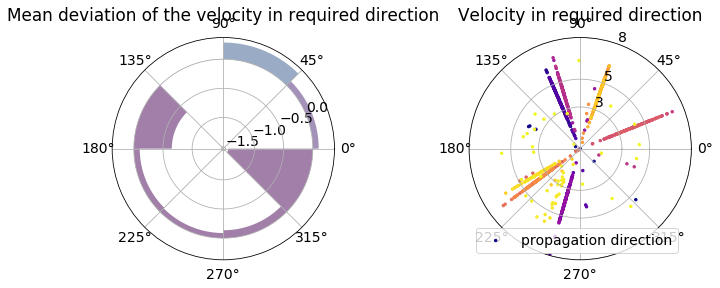

Angle =   [  45.   90.  135.  180.  225.  270.  315.  360.]
Offset =  [ 0.  0.  0.  0.  0.  0.  0.  0.]
Counts =  [ 144.  156.  266.   11.  215.  192.    6.    9.]


In [29]:
distlaser = np.zeros(maxlength)
parts = 8
distangle = np.zeros((parts,4))     #0 - angle, 1 - distlaser, 2 - counts, 3 - velocity
for i in range(parts): distangle[i,0] = (i+1)/parts * 360
for i in range(maxlength):                        #Statistic over the laser offset (and the velocity in required direction) vs the required direction
    distlaser[i] = np.sqrt(pow(xlaser[i,0]-particles[i,0,0],2)+pow(ylaser[i,0]-particles[i,0,1],2))
    if abs(distlaser[i]-offset) > 1.5:
        #print('To high laser offset, t = ',round(i*dt,2),' s - dist = ',round(abs(distlaser[i]-offset),1),' µm')
        distlaser[i] = distlaser[i-1]
    if laserangle[i]<distangle[0,0]:
        distangle[0,1] += distlaser[i]
        distangle[0,2] += 1
        distangle[0,3] += velocity[i]
    else:
        for j in range(1,parts):
            if laserangle[i] > distangle[j-1,0] and laserangle[i] < distangle[j,0]:
                distangle[j,1] += distlaser[i]
                distangle[j,2] += 1
                distangle[j,3] += velocity[i]
distangle[:,1] /= distangle[:,2]
distangle[:,3] /= distangle[:,2]
timewave = np.linspace(0,maxlength*dt,maxlength,endpoint=False)

fig=plt.figure(1, figsize = (10,5) )
theta = np.linspace(0, 2 * np.pi, parts, endpoint=False)
radii = distangle[:,3] - np.mean(velocity)
width = 2*np.pi / (parts)
theta += width/2
ax = plt.subplot(121, projection='polar')
ax.set(aspect="equal",title='Mean deviation of the velocity in required direction')
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.viridis(r))
    bar.set_alpha(0.5)
r = velocity
theta = particles[:,0,3]*np.pi/180
colorwave = cm.plasma(np.linspace(0, 1, maxlength))
ax =plt.subplot(1,2, 2, projection='polar')
plt.title('Velocity in required direction')
ax.scatter(theta, r,s=6,label='propagation direction',color=colorwave[:])
#ax.scatter(theta2, r,s=2,label='required direction')
ax.set_rmax(max(velocity))
ax.set_rticks([round(max(velocity)/3,0), round(2*max(velocity)/3,0), round(max(velocity))])
ax.set_rlabel_position(70)
ax.grid(True)
plt.legend()
plt.tight_layout() 
plt.savefig('Velocity angle'+str(printnum)+'.pdf', format='pdf')
plt.show()

showoffset=[];showoffset = distangle[:,1]
for i in range(parts):
    showoffset[i]=round(showoffset[i],1)
print('Angle =  ',distangle[:,0])
print('Offset = ',showoffset)
print('Counts = ',distangle[:,2])

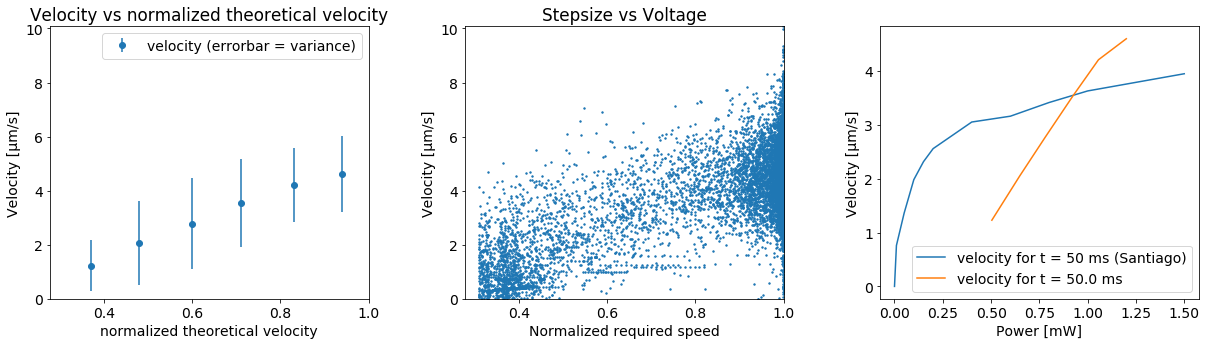

voltage =  [ 0.42  0.54  0.65  0.77  0.88  1.  ]
speed =    [ 1.23  2.05  2.77  3.54  4.21  4.6 ]
counts =   [ 1079.   514.   367.   371.   583.  7025.]


In [15]:
value = velo[:,0]
steps2 = 6
speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
speedcollect=np.zeros((steps2,maxlength))
for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
    if value[i] < speedhisto[0,0]:
        speedhisto[0,1] += velocity[i]
        speedcollect[0,int(speedhisto[0,2])] = velocity[i]
        speedhisto[0,2] += 1
    else:
        for j in range(1,steps2):
            if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                speedhisto[j,1] += velocity[i]
                speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                speedhisto[j,2] += 1
speedhisto[:,1] /= speedhisto[:,2]
for i in range(maxlength):
    for j in range(steps2):
        if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan
valueprint = np.zeros(steps2);veloprint = np.zeros(steps2); plotvaluehisto = np.zeros(steps2)
for i in range(steps2):                          #Convert into a printable value
    valueprint[i] = round(speedhisto[i,0],2)
    veloprint[i] = round(speedhisto[i,1],2)
    plotvaluehisto[i] = round(speedhisto[i,0]-(1-min(value))/(2*steps2),2)
    speedhisto[i,3] = nanvar(speedcollect[i,:])  
data = []
for i in range(steps2): data.append(speedcollect[i,:int(speedhisto[i,2])])

folder2 = '/Users/alex/Documents/Projects/Santiago speed'
power = np.loadtxt(r''+str(folder2)+'/power.txt')
speed = np.loadtxt(r''+str(folder2)+'/v_paralel_50ms.txt')
    
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(17, 5), sharey=True)
ax = plt.subplot(1, 3, 1)
plt.errorbar(plotvaluehisto[:], speedhisto[:,1],yerr=speedhisto[:,3], fmt='o',label='velocity (errorbar = variance)') #(errorbar = variance/sqrt(N))
plt.title('Velocity vs normalized theoretical velocity')
plt.xlabel('normalized theoretical velocity')
plt.ylabel('Velocity [µm/s]')
plt.ylim([0,max(velocity)])
plt.xlim([0.9*min(value),1])
plt.legend()
ax = plt.subplot(1, 3, 2)
plt.title('Stepsize vs Voltage')
plt.xlabel('Normalized required speed')
plt.ylabel('Velocity [µm/s]')
plt.scatter(value,velocity, s=2)
plt.ylim([0,max(velocity)])
plt.xlim([0.9*min(value),1])
ax = plt.subplot(1, 3, 3)
plt.plot(power,speed,label='velocity for t = 50 ms (Santiago)')
plt.plot(maxpower*valueprint,veloprint,label='velocity for t = '+str(round(1000*dt,0))+' ms')
plt.xlabel('Power [mW]')
plt.ylabel('Velocity [µm/s]')
plt.legend()
plt.tight_layout() 
plt.savefig('Velocity vs Normalized required speed'+str(printnum)+'.pdf', format='pdf')
plt.show()
    
print('voltage = ',valueprint)
print('speed =   ',veloprint)
print('counts =  ',speedhisto[:,2])

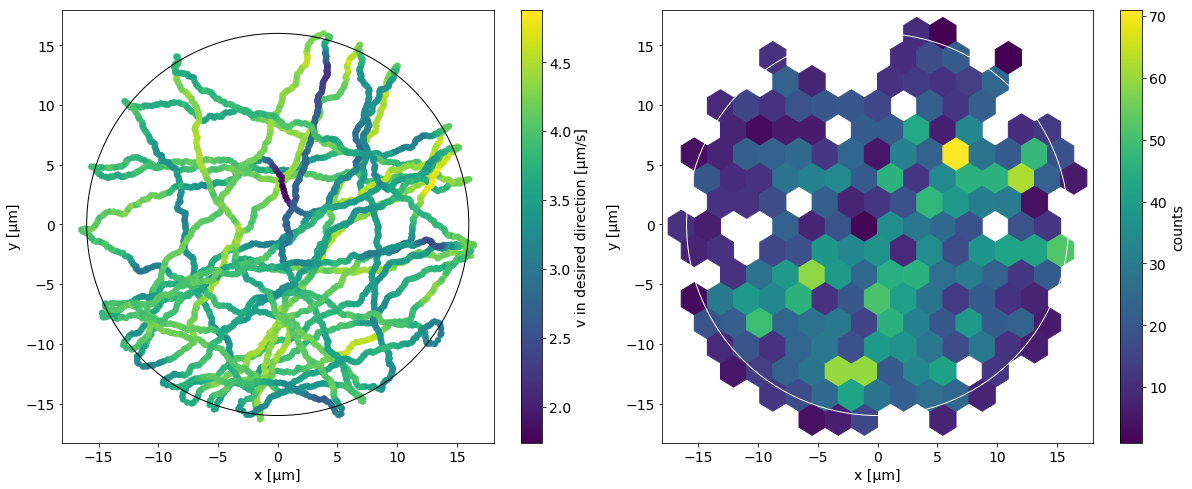

In [13]:
x = particles[:,0,0]
y = particles[:,0,1]
factor = 1.08
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()
x = particles[smoothvalue:maxlength-smoothvalue,0,0]
y = particles[smoothvalue:maxlength-smoothvalue,0,1]
v = smoothit[smoothvalue:maxlength-smoothvalue]
gridsizevalue = 15
fig, axs = plt.subplots(ncols=2, figsize=(17,7), sharex='all')
fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
ax = axs[0]
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
im = ax.scatter(x,y,c=v,linewidths=0.5)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.tick_params(axis='y')
#plt.title('Particle position')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
ax.axis('equal')
cb = fig.colorbar(im, ax=ax)
cb.set_label('v in desired direction [µm/s]')
x = particles[:,0,0]
y = particles[:,0,1]
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = axs[1]
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
ax.axis('equal')
plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(printnum)+'.pdf', format='pdf')
plt.savefig('Path of the particle colored'+str(printnum)+'.svg', format='svg')
plt.show()

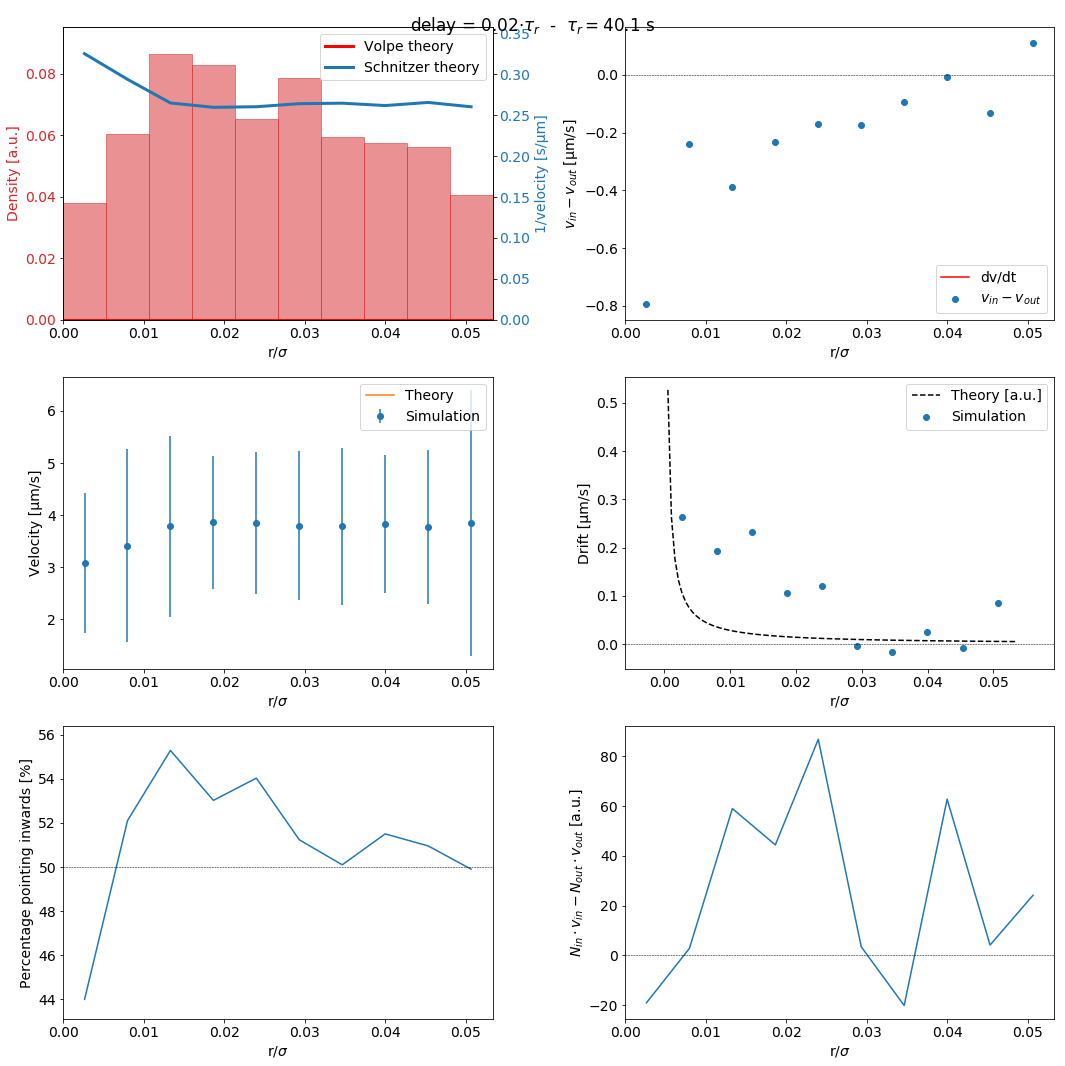

In [30]:
    savefolder ='.'
    driftdelay = 1
    particlesdisplay = np.zeros((maxlength,1,5))
    particlesdisplay[:,0,0] = particles[:,0,0];particlesdisplay[:,0,1] = particles[:,0,1]
    #particlesdisplay = (particlesdisplay-videosize/2)*pxtomum
    distancetocenter=[]                                    #Calc velocity 
    distancetocenter=np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
    directionvector = np.zeros((maxlength,2))
    movingvector = np.zeros((maxlength,2))
    velocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)
    velocitywithdiffusion=np.zeros(maxlength)
    directionvector[:,0] = np.cos(particles[:,0,3]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,0,3]*np.pi/180)
    for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
        movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
        movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
        stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
        velocity[i] = stepsize[i]/dt
        
    value = particles[:,0,2]
    steps2 = 6
    speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
    speedcollect=np.zeros((steps2,maxlength))
    for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
    for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
        if value[i] < speedhisto[0,0]:
            speedhisto[0,1] += velocity[i]
            speedcollect[0,int(speedhisto[0,2])] = velocity[i]
            speedhisto[0,2] += 1
        else:
            for j in range(1,steps2):
                if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                    speedhisto[j,1] += velocity[i]
                    speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                    speedhisto[j,2] += 1
    speedhisto[:,1] /= speedhisto[:,2]
    maxvelocitymeasured = speedhisto[-1,1]
    
    startpoint = []; endpoint =[]
    if distancetocenter[0] < boundaryradius*pxtomum:
        startpoint.append(0)
        check = 0
    else: check = 1; remi = -1   
    count = 0
    for i in range(1,maxlength):
        if distancetocenter[i] > boundaryradius*pxtomum:
            if check == 0:
                remi = i
                check = 1
            count += 1
        if check == 1: 
            if distancetocenter[i] < boundaryradius*pxtomum:
                check = 0
                if remi != -1:
                    startpoint.append(i)
                    endpoint.append(remi)
                else: startpoint.append(i)
            else: count += 1   
    if check == 1: endpoint.append(remi)
    else: endpoint.append(maxlength-1)
    
    newangle = np.zeros(maxlength); newangle = particles[:,0,3].copy()    #MSD for the theoretic moving direction
    diff = np.zeros(3)
    for i in range(1,maxlength):
        diff[0] = abs(newangle[i]-newangle[i-1])
        diff[1] = abs(newangle[i]-newangle[i-1]+360)
        diff[2] = abs(newangle[i]-newangle[i-1]-360)
        mini = min(diff)
        if mini != diff[0]:
            if mini == diff[1]: newangle[i:] += 360
            else: newangle[i:] -= 360
    for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]

    if noise != 0:
        check = True; i = 1
        reorwave= np.zeros((maxlength,2))
        while check == True:
            diff = np.zeros(maxlength-i)
            for j in range(i,maxlength): diff[j-i] = abs(newangle[j] - newangle[j-i])  #Calculate the direction change for i steps
            mean = np.mean(diff[:maxlength-i])   #Calculate the standard derivation
            reorwave[i,0] = i*dt
            reorwave[i,1] = mean
            if mean/57.3 >= 1: 
                check = False
                reorlen = i
            else: i += 1 
            if i == stepsexp:
                reorlen = i
                i = 666/dt
                check = False       
        reorientationtime = i*dt 
    else: reorientationtime = 666

    radialdata = np.zeros((steps,15))  #0 - bins, 1 - counts, 2 - v, 3 - verr, 4 - v outwards, 5 - v outwards err
    base=boundaryradius*pxtomum/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    for i in range(steps): radialdata[i,0] = i*base
    averagebinposition = np.zeros(steps-1)
    for i in range(1,steps): averagebinposition[i-1] = (radialdata[i,0]+radialdata[i-1,0])/2

    step = np.zeros(maxlength); shell = np.zeros(maxlength); inout = []; radialdrift = 0
    collectdrift = np.zeros((maxlength,steps))
    collectvelocity = np.zeros((maxlength,steps,3))
    count = np.zeros((steps,3))
    for i in range(1,maxlength):
        j = 0
        check = False
        while check == False:
            if distancetocenter[i] < radialdata[j,0] and distancetocenter[i] > radialdata[j-1,0]:
                check = True
                radialdata[j,1] += 1
                collectvelocity[int(count[j,0]),j,0] = velocity[i]
                count[j,0] += 1                        
                radialdrift = distancetocenter[i]-distancetocenter[i-driftdelay]
                collectdrift[int(count[j,0]),j] = radialdrift
                step[i] = i; shell[i] = round(averagebinposition[j-1],2)
                if radialdrift > 0:  #moving outwards
                    collectvelocity[int(count[j,1]),j,1] = velocity[i]
                    count[j,1] += 1
                    inout.append('outwards')
                if radialdrift < 0:  #moving inwards
                    collectvelocity[int(count[j,2]),j,2] = velocity[i]
                    count[j,2] += 1
                    inout.append('inwards')
            else: j += 1
            if j == steps: check = True
        if shell[i] == 0:
            step[i] = i; shell[i] = 888
            if radialdrift < 0: inout.append('inwards')
            else: inout.append('outwards')

    for i in range(1,steps): 
        radialdata[i,2] = np.mean(collectvelocity[:int(count[i,0]),i,0])    #total velocity
        radialdata[i,3] = np.nanvar(collectvelocity[:int(count[i,0]),i,0])
        radialdata[i,4] = np.mean(collectvelocity[:int(count[i,1]),i,1])    #moving outwards
        radialdata[i,5] = np.nanvar(collectvelocity[:int(count[i,1]),i,1])
        radialdata[i,6] = np.mean(collectvelocity[:int(count[i,2]),i,2])    #moving inwards
        radialdata[i,7] = np.nanvar(collectvelocity[:int(count[i,2]),i,2])
        radialdata[i,8] = radialdata[i,1]/averagebinposition[i-1]                   #density
        radialdata[i,11] = -np.mean(collectdrift[:int(count[i,0]),i])/dt
        radialdata[i,12] = np.nanvar(collectdrift[:int(count[i,0]),i])/dt
    dr = radialdata[1,0]
    sumdensity = sum(radialdata[1:,8]*dr)
    radialdata[1:,8] /= sumdensity                                                  
    radialdata[1:,9] = radialdata[1:,6] - radialdata[1:,4]                  #velocity difference
    radialdata[1:,10] = np.sqrt(radialdata[1:,7]**2 + radialdata[1:,5]**2)
    meandensity = sum(averagebinposition*radialdata[1:,8])
    radialdata[1:,13] = count[1:,2]*radialdata[1:,6] - count[1:,1]*radialdata[1:,4]
    radialdata[1:,14] = count[1:,2]/(count[1:,1]+count[1:,2])*100

    dd, v = calcvelocity(boundaryradius*pxtomum,sigmavelo*pxtomum,vfactor,amplitude,vmin)
    diffv = np.gradient(v)/(dd[1]-dd[0])
    maxpos = np.argmax(diffv)
    maxdist = dd[maxpos]
    if maxpos == 0: maxdist = boundaryradius
    sigmawave = np.zeros(steps)
    base=boundaryradius*pxtomum/maxdist/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    for i in range(steps): sigmawave[i] = i*base
    averagesigmaposition = np.zeros(steps-1)
    for i in range(1,steps): averagesigmaposition[i-1] = (sigmawave[i]+sigmawave[i-1])/2
    ddnew = np.linspace(0,boundaryradius*pxtomum/maxdist,100)

    dr = dd[1]*1e6   
    string_temp = savefolder + '/PlotRadial/'
    if not os.path.exists(string_temp):
        os.makedirs(string_temp) 
    fig=plt.figure(1, figsize = (15,15) )
    ax1 = plt.subplot(3,2,1)
    color = 'tab:red'
    ax1.set_xlabel(r'r/$\sigma$')
    ax1.set_ylabel('Density [a.u.]', color=color)
    bars = ax1.bar(averagesigmaposition, radialdata[1:,8],base, color=color,alpha = 0.5, edgecolor = color,label='Simulation')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0,1.1*max(radialdata[1:,8])])
    ax1.set_xlim([0,boundaryradius*pxtomum/maxdist])
    ax1.axvline(x=meandensity,linewidth=0.5, color = 'k',linestyle='--',label = 'mean value')
    ax1.set_title(' ')
    theory = 1/(v**(1+delay*dt/reorientationtime))
    theory /= np.nansum(theory*dr)             
    line1 = ax1.plot(ddnew,theory, color='red', linewidth = 3,label = 'Volpe theory')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('1/velocity [s/µm]', color=color)  # we already handled the x-label with ax1
    line2 = ax2.plot(averagesigmaposition,1/radialdata[1:,2], color=color, linewidth = 3,label='Schnitzer theory')
    #line2 = ax2.plot(dd,1/v, color=color, linewidth = 3,label='Schnitzer theory')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0,1.1*np.nanmax(1/radialdata[1:,2])])
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns,labs)

    ax3 = plt.subplot(3,2,2)
    diffv = np.gradient(v)/(dd[1]-dd[0])
    ax3.set_ylabel('$v_{in}-v_{out}$ [µm/s]')
    ax3.set_xlabel(r'r/$\sigma$')
    ax3.set_title(' ')
    #ax3.errorbar(averagebinposition,radialdata[1:,9],yerr=radialdata[1:,10], fmt='o',label ='$v_{in} - v_{out}$')
    ax3.scatter(averagesigmaposition,radialdata[1:,9],label ='$v_{in} - v_{out}$')
    ax3.plot(ddnew,diffv*np.nanmax(abs(radialdata[1:,9]))/max(diffv),color='r',label = 'dv/dt')
    ax3.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    ax3.set_xlim([0,boundaryradius*pxtomum/maxdist])
    ax3.legend()

    ax4 = plt.subplot(3,2,3)
    ax4.errorbar(averagesigmaposition, radialdata[1:,2],yerr=radialdata[1:,3], fmt='o',label='Simulation')
    ax4.plot(ddnew,v*maxvelocitymeasured,label='Theory')
    ax4.set_xlabel(r'r/$\sigma$')
    ax4.set_ylabel('Velocity [µm/s]')
    ax4.set_xlim([0,boundaryradius*pxtomum/maxdist])
    ax4.legend()

    ax5 = plt.subplot(3,2,4)
    #plt.errorbar(averagebinposition,radialdata[1:,11],yerr=radialdata[1:,12], fmt='o',label='Simulation')
    plt.scatter(averagesigmaposition,radialdata[1:,11],label='Simulation')
    ax5.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    drifttheory = calcdrifttheory(v,dd,reorientationtime,delay*dt,dr)
    plt.plot(ddnew,drifttheory/drifttheory[2]*radialdata[1,11],'k--',label='Theory [a.u.]')
    #drifttheory = calcdrifttheory(radialdata[1:,2],averagebinposition,reorientationtime,delay*dt,base)
    #plt.plot(averagebinposition,drifttheory*max(radialdata[1:,11]/max(drifttheory)),'k--',label='Theory [a.u.]')
    ax5.set_xlabel(r'r/$\sigma$')
    ax5.set_ylabel('Drift [µm/s]')
    ax5.legend()

    percentage2 = count[:,2]/(count[:,1]+count[:,2])*100
    ax6 = plt.subplot(3,2,5)
    plt.plot(averagesigmaposition,radialdata[1:,14])
    plt.xlabel(r'r/$\sigma$')
    plt.ylabel('Percentage pointing inwards [%]')
    plt.axvline(x=boundaryradius/maxdist,linewidth=0.5, color = 'k',linestyle='--')
    plt.axhline(y=50,linewidth=0.5, color = 'k',linestyle='--')
    plt.ylim([0.98*min(radialdata[1:,14]),1.02*max(radialdata[1:,14])])
    plt.xlim([0,boundaryradius*pxtomum/maxdist])

    ax7 = plt.subplot(3,2,6)
    plt.plot(averagesigmaposition,radialdata[1:,13])
    plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    plt.xlabel(r'r/$\sigma$')
    plt.ylabel(r'$N_{in} \cdot v_{in} - N_{out} \cdot v_{out}$ [a.u.]')
    plt.xlim([0,boundaryradius*pxtomum/maxdist])
    plt.axvline(x=boundaryradius*pxtomum/maxdist,linewidth=0.5, color = 'k',linestyle='--')

    plt.suptitle('delay = '+str(round(delay*dt/reorientationtime,2))+r'$\cdot \tau_{r}$  -  $\tau_{r} = $'+str(round(reorientationtime,1))+' s')
    plt.tight_layout() 
    plt.savefig(string_temp+'Density layout'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
    plt.show()    